In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [2]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/aco_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:
import numpy as np

def calculate_conflicts(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    num = 0

    for edge in graph.edges():
        indicator = True

        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                indicator = False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                indicator = False

        if indicator:
            num += 1
    
    return len(graph.edges()) - num

def ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_edges  # Initially set the number of colors to the number of nodes
    
    # Initialize pheromone matrix with small random values
    pheromone_matrix = np.random.rand(num_edges, num_colors)
    
    # Initialize best coloring and its value
    best_coloring = np.zeros(num_edges, dtype=int)
    best_value = float('inf')
    
    for iteration in range(num_iterations):
        # Initialize ant solutions
        ant_solutions = np.zeros((num_ants, num_edges), dtype=int)
        
        # Construct ant solutions
        for ant in range(num_ants):
            for edge in range(num_edges):
                probabilities = np.zeros(num_colors)
                if graph.has_node(edge):  # Check if edge is a valid node
                    for color in range(num_colors):
                        probabilities[color] = (pheromone_matrix[edge][color] ** alpha) * ((1 / (graph.degree(edge) + 1)) ** beta)
                    
                sum_probabilities = np.sum(probabilities)
                if sum_probabilities == 0:
                    probabilities = np.ones_like(probabilities) / len(probabilities)
                else:
                    probabilities /= sum_probabilities
                ant_solutions[ant][edge] = np.random.choice(range(num_colors), p=probabilities)
        
        # Update pheromone matrix locally
        for ant in range(num_ants):
            value = calculate_conflicts(graph, ant_solutions[ant])
            if value < best_value:
                best_value = value
                best_coloring = ant_solutions[ant]
                for edge in range(num_edges):
                    pheromone_matrix[edge][ant_solutions[ant][edge]] += pheromone_deposit
        
        # Global update of pheromone matrix
        pheromone_matrix *= (1 - evaporation_rate)
        for edge in range(num_edges):
            for color in range(num_colors):
                if color == best_coloring[edge]:
                    pheromone_matrix[edge][color] += pheromone_deposit / (best_value + 1e-10)

    # Update number of colors if a better coloring is found
        if value < best_value  and is_valid_coloring(graph, ant_solutions[ant]):
            best_coloring = ant_solutions[ant]
    
    return best_coloring, best_value, len(np.unique(best_coloring))

In [9]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    num_ants = 10
    num_iterations = 100 
    
    alpha = 1
    beta = 1
    evaporation_rate = 0.2
    pheromone_deposit = 1
    
    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_coloring, best_value, num_colors = ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit)
            end_time = time.time()
            print("Best Coloring:", best_coloring)
            print("Best Value:", best_value)
            print("Number of Colors:", num_colors)
            write_output(graph, file, best_coloring, num_colors, start_time, end_time)

Running test graph_3_edges.txt...
Best Coloring: [2 1 0]
Best Value: 0
Number of Colors: 3
[2 1 0]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 3


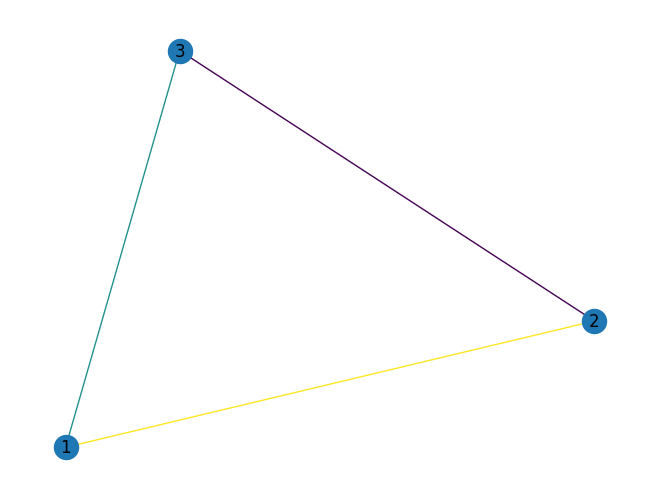

Time taken: 0.3556361198425293 seconds

Running test graph_5_edges.txt...
Best Coloring: [0 3 2 3 0]
Best Value: 0
Number of Colors: 3
[0 3 2 3 0]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 3


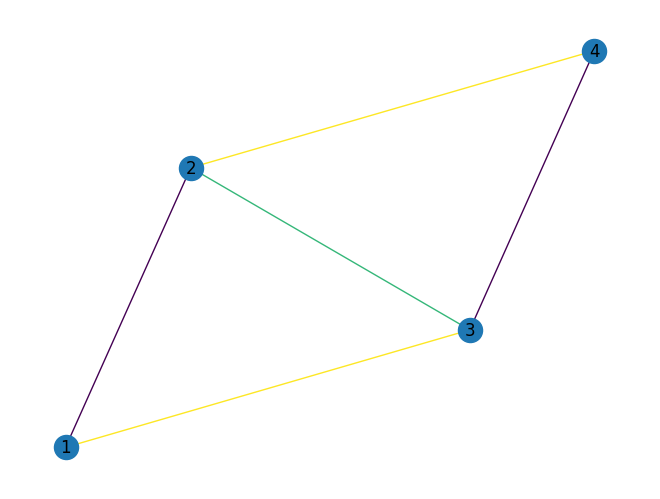

Time taken: 0.45552563667297363 seconds

Running test graph_5_edges_2.txt...
Best Coloring: [3 2 0 0 1]
Best Value: 0
Number of Colors: 4
[3 2 0 0 1]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 4


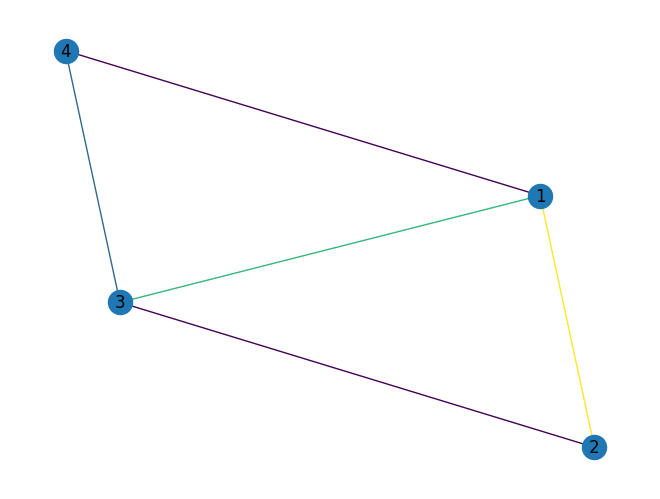

Time taken: 0.4406871795654297 seconds

Running test graph_6_edges.txt...
Best Coloring: [5 2 3 1 5 4]
Best Value: 0
Number of Colors: 5
[5 2 3 1 5 4]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


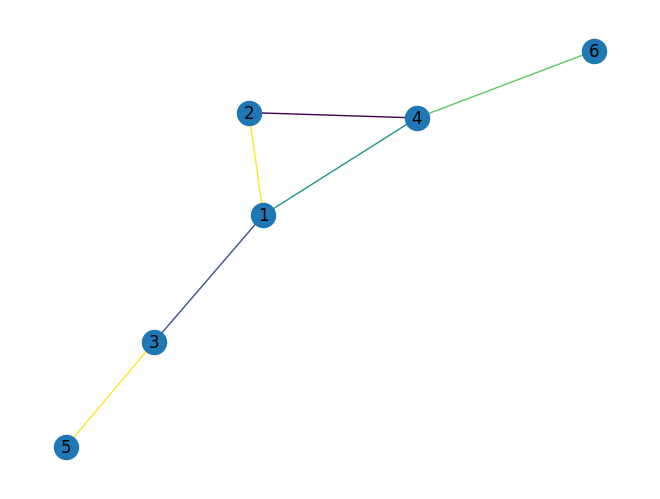

Time taken: 0.5826723575592041 seconds

Running test graph_7_edges.txt...
Best Coloring: [2 3 1 3 4 1 2]
Best Value: 0
Number of Colors: 4
[2 3 1 3 4 1 2]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 4


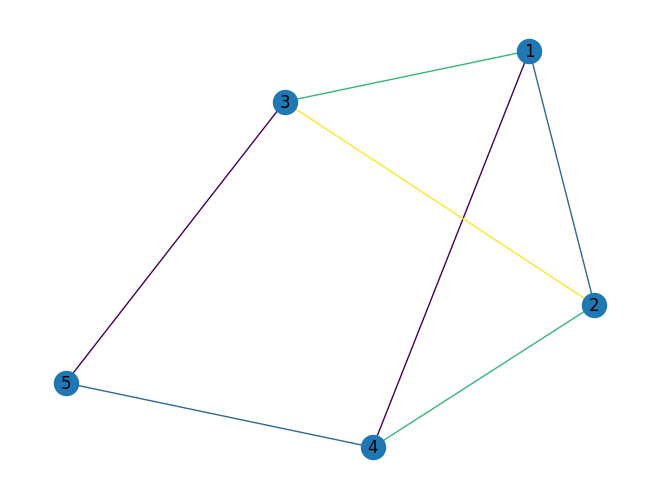

Time taken: 0.605914831161499 seconds

Running test graph_7_edges_2.txt...
Best Coloring: [0 4 2 1 3 2 4]
Best Value: 0
Number of Colors: 5
[0 4 2 1 3 2 4]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


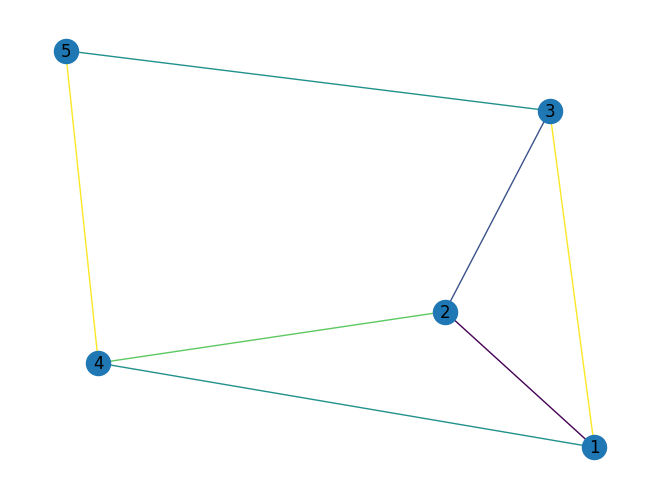

Time taken: 0.5452659130096436 seconds

Running test graph_7_edges_3.txt...
Best Coloring: [0 4 2 6 3 0 4]
Best Value: 0
Number of Colors: 5
[0 4 2 6 3 0 4]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


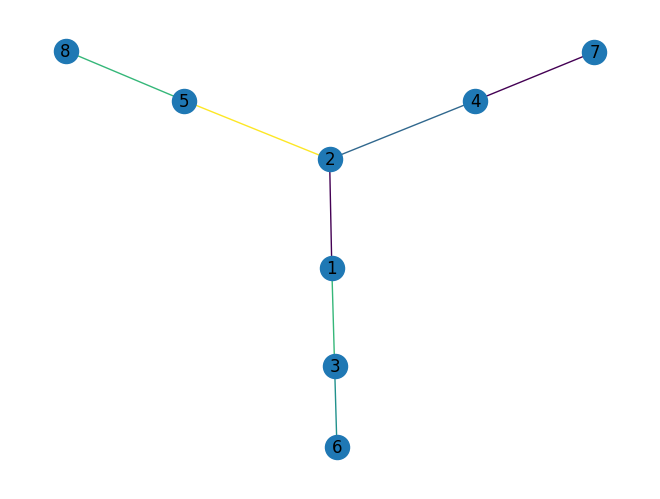

Time taken: 0.5749258995056152 seconds

Running test graph_8_edges.txt...
Best Coloring: [7 1 2 1 3 3 6 5]
Best Value: 0
Number of Colors: 6
[7 1 2 1 3 3 6 5]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 6


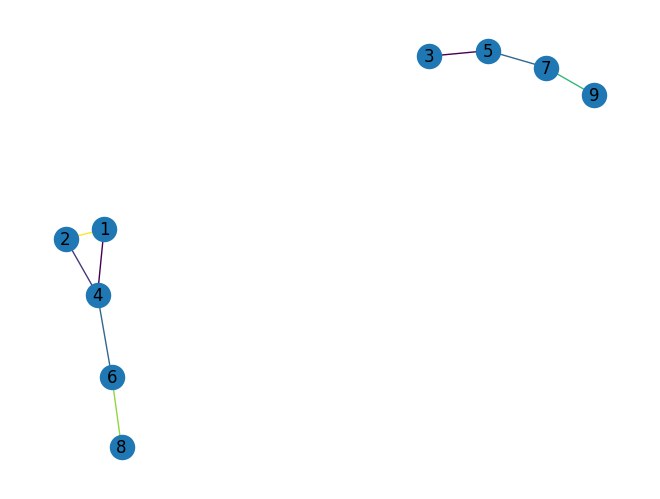

Time taken: 0.6539499759674072 seconds

Running test graph_9_edges.txt...
Best Coloring: [3 0 2 6 2 6 1 1 3]
Best Value: 0
Number of Colors: 5
[3 0 2 6 2 6 1 1 3]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


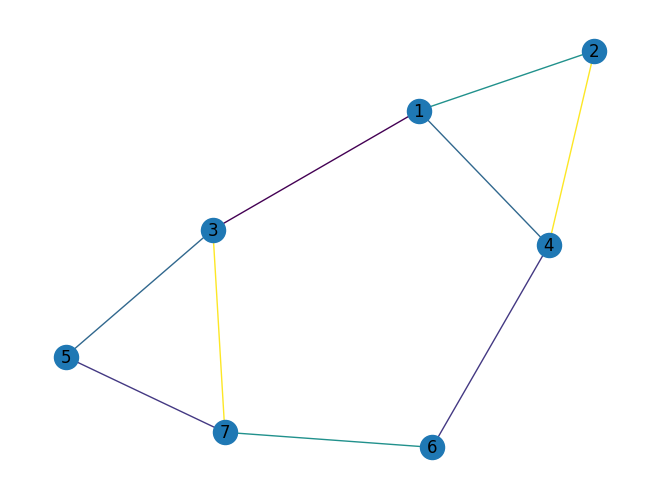

Time taken: 0.7518842220306396 seconds

Running test graph_9_edges_2.txt...
Best Coloring: [4 1 2 0 8 0 5 0 5]
Best Value: 0
Number of Colors: 6
[4 1 2 0 8 0 5 0 5]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 6


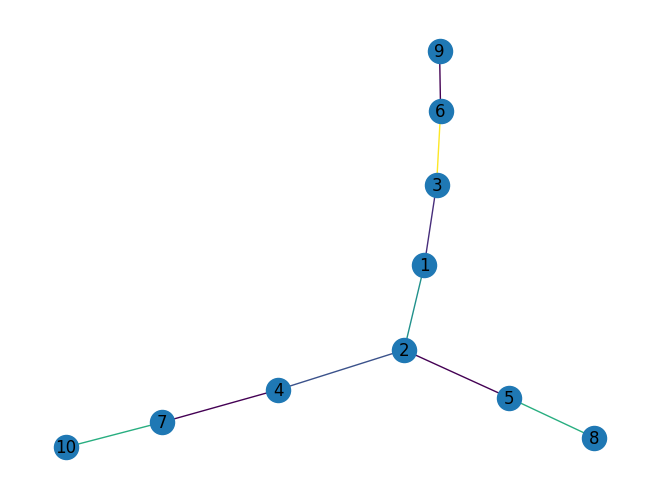

Time taken: 0.779430627822876 seconds

Running test graph_10_edges.txt...
Best Coloring: [3 7 2 0 8 3 2 5 1 9]
Best Value: 0
Number of Colors: 8
[3 7 2 0 8 3 2 5 1 9]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


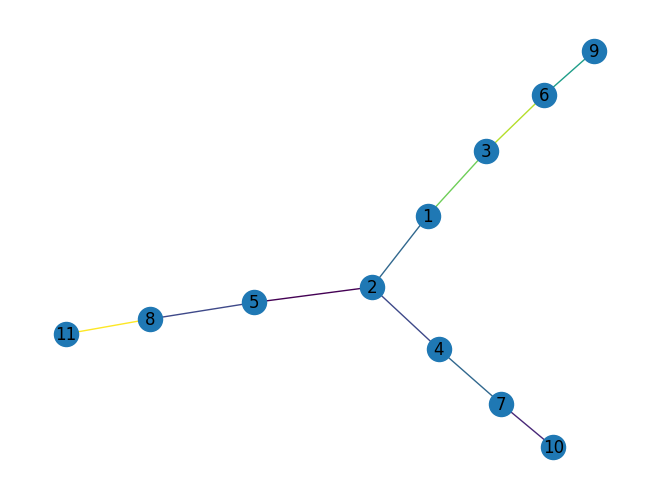

Time taken: 0.9648303985595703 seconds

Running test graph_10_edges_2.txt...
Best Coloring: [9 0 4 5 6 2 3 9 6 5]
Best Value: 0
Number of Colors: 7
[9 0 4 5 6 2 3 9 6 5]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


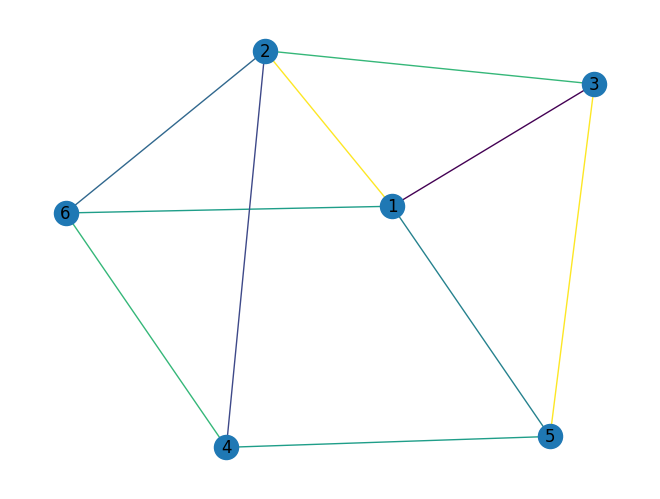

Time taken: 0.8954315185546875 seconds

Running test graph_10_edges_3.txt...
Best Coloring: [2 6 0 7 5 4 9 8 0 7]
Best Value: 0
Number of Colors: 8
[2 6 0 7 5 4 9 8 0 7]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


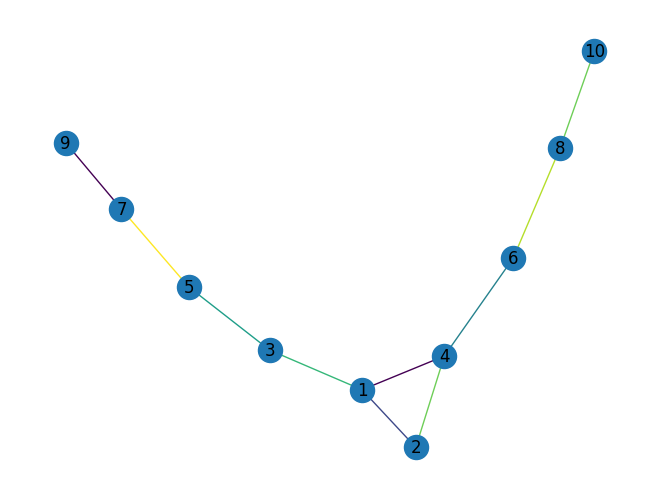

Time taken: 0.946599006652832 seconds

Running test graph_11_edges.txt...
Best Coloring: [ 8  4 10  9  2  3 10  2  5  1  7]
Best Value: 0
Number of Colors: 9
[ 8  4 10  9  2  3 10  2  5  1  7]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 9


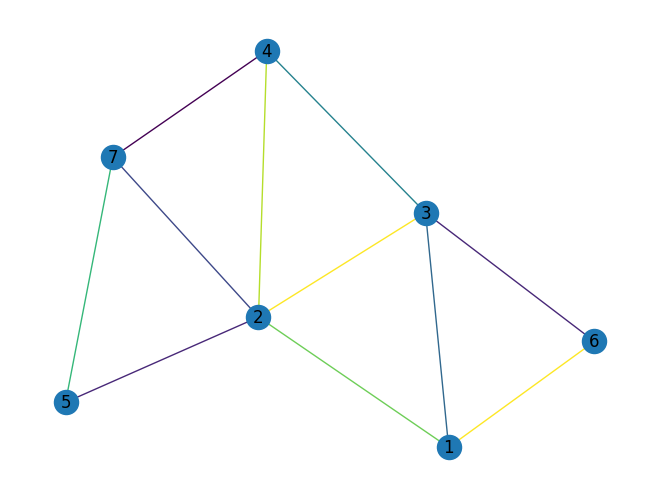

Time taken: 1.042720079421997 seconds

Running test graph_11_edges_2s.txt...
Best Coloring: [6 9 0 3 8 7 4 5 2 6 3]
Best Value: 0
Number of Colors: 9
[6 9 0 3 8 7 4 5 2 6 3]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 9


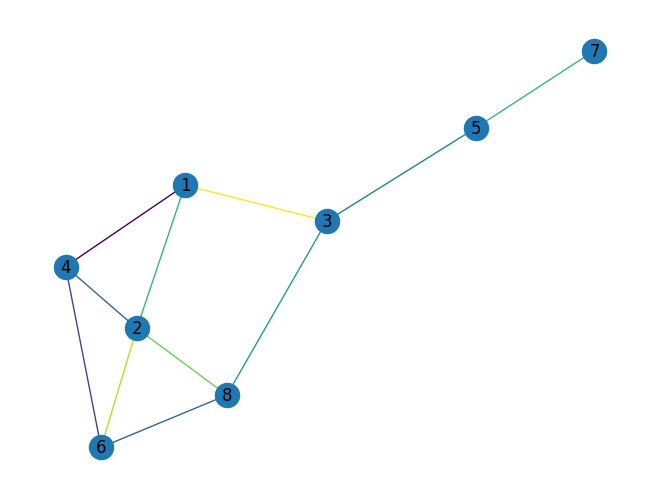

Time taken: 1.2109813690185547 seconds

Running test graph_11_edges_3.txt...
Best Coloring: [ 2  7  4  5 10  3  8  1 10 10  9]
Best Value: 0
Number of Colors: 9
[ 2  7  4  5 10  3  8  1 10 10  9]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 9


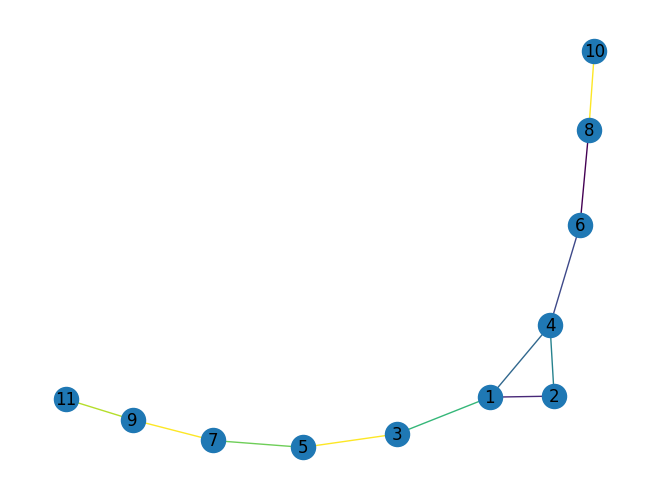

Time taken: 1.3212740421295166 seconds

Running test graph_11_edges_4.txt...
Best Coloring: [ 1  9  4  7 10  2 10  6  8  2  7]
Best Value: 0
Number of Colors: 8
[ 1  9  4  7 10  2 10  6  8  2  7]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


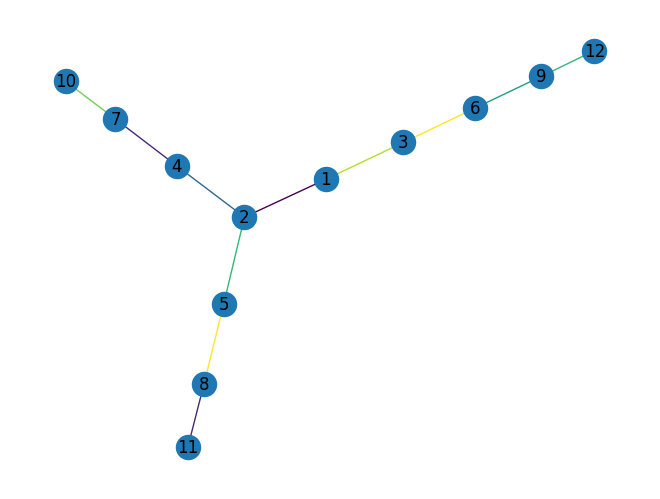

Time taken: 1.0995965003967285 seconds

Running test graph_12_edges.txt...
Best Coloring: [ 6 11  0  2  7  1  1  0  3  4  1  0]
Best Value: 0
Number of Colors: 8
[ 6 11  0  2  7  1  1  0  3  4  1  0]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


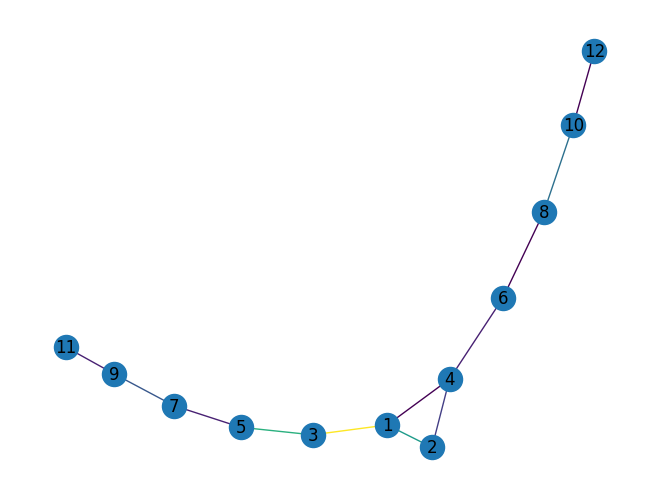

Time taken: 1.0916736125946045 seconds

Running test graph_12_edges_2.txt...
Best Coloring: [ 1  5  7 10 10  0  1 11  5  8  5  8]
Best Value: 0
Number of Colors: 7
[ 1  5  7 10 10  0  1 11  5  8  5  8]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


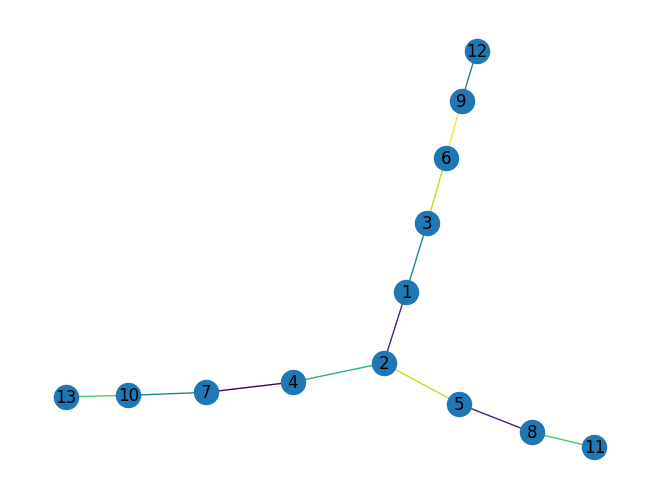

Time taken: 1.7413663864135742 seconds

Running test graph_15_edges.txt...
Best Coloring: [ 9  5  7 12  6 10 14 11  8  5  2 12  3  0  7]
Best Value: 0
Number of Colors: 12
[ 9  5  7 12  6 10 14 11  8  5  2 12  3  0  7]
Minimum edge coloring found.
Number of colors: 12
Number of iterations: 12


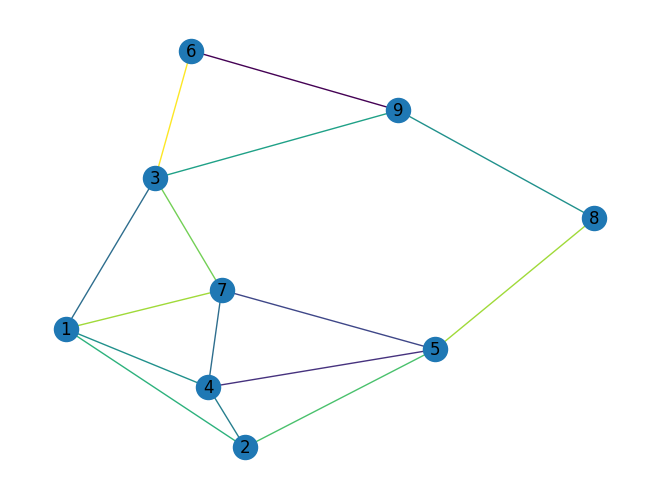

Time taken: 1.6318318843841553 seconds



In [10]:
with open('./results/aco_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')